## Inversion using optimization scheme

### 2 Layers model

In [1]:
%matplotlib widget

In [2]:
import pygimli as pg
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0

import sys
sys.path.insert(1, '../src')

from PlotModel import PlotModelCond_2lay, Plot3Models_2lay, PlotErrorSpace, PlotData, rmse_a
from EM1D import EMforward2lay, GlobalSearch, ErrorSpace

### Load True Model

In [49]:
# Import the conductivities and thicknesses used to create the LU table
conds = np.load('../data/conds_samples.npy')
thick = np.load('../data/thick_samples.npy')

# Import true models and data 
model_true = np.load('../data/model_true.npy')

# Data array for all the 1D stitched models
data_true = np.load('../data/data_true.npy')

In [50]:
sigmas_true = model_true[:,:2]
depths_true = np.zeros_like((model_true[:,1:]))
depths_true[:,1] = model_true[:,2]

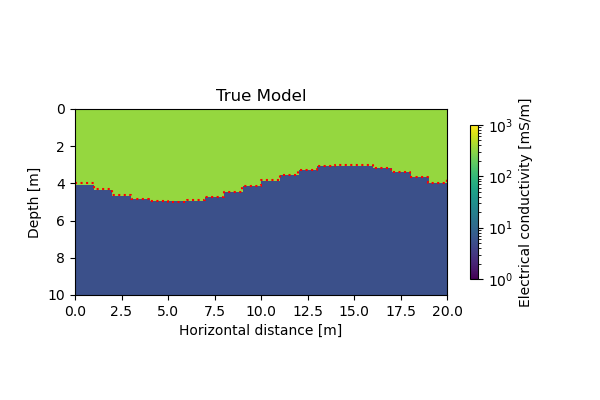

In [51]:
PlotModelCond_2lay(sigmas_true, depths_true, depths_true)
plt.title('True Model')
plt.show()

### Optimization using Q + IP

In [76]:
# Create forward modeller class

class EMforward(pg.Modelling):
    def __init__(self):
        """Initialize the model."""
        super().__init__()        
    def response(self, x):
        sig1 = x[0]
        sig2 = x[1]
        thick1 = x[2]
        Z = EMforward2lay(sig1, sig2, thick1)                           
        return Z               
    def createStartModel(self, dataVals):
        thk_ini = [3]
        sig_ini =[1/5, 1/100]
        x0 = sig_ini + thk_ini
        return np.array(x0)

In [77]:
# Initialize the forward modelling class
EMf = EMforward()

# Define inversion transformations
transData = pg.trans.TransLog() # log transformation for data
transModel = pg.trans.TransLog()  # log-transform ensures thk and res >0

# Create inversion
invEM = pg.Inversion()
invEM.setForwardOperator(EMf)

invEM.transModel = transModel
invEM.transData = transData

In [78]:
# Relative error array
error = 1e-3 # introduce here the error you want to test
relativeError = np.ones_like(data_true[0]) * error

In [79]:
# Start inversion

model_est = np.zeros_like(model_true)
chi2hist = [] # empty array to store the chi2 history
modelhist = [] # empty array to store the model history

npos = len(data_true)

# Perform inversion for each 1D model per position in stitched section
for pos in range(npos):
    dataE = data_true[pos].copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0
    model_est_pos = invEM.run(dataE, relativeError, verbose=False, lam=100, maxIter=40)
    chi2hist.append(invEM.chi2History)
    modelhist.append(invEM.modelHistory)
    model_est[pos] = model_est_pos

17/07/23 - 13:58:59 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 13:59:00 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 13:59:01 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 13:59:02 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 13:59:03 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 13:59:04 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 13:59:06 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 13:59:07 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 13:59:08 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 13:59:09 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 13:59:10 

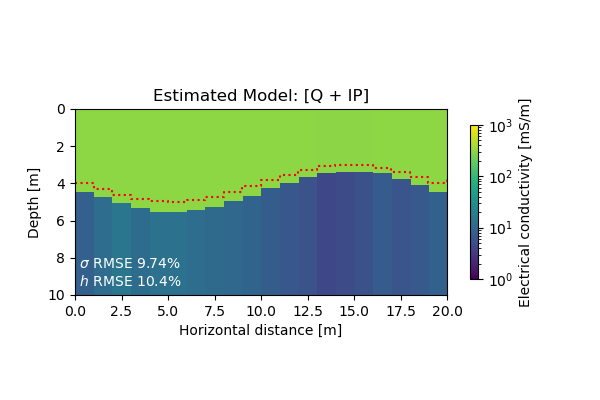

In [81]:
# Results of estimated model

sigmas_est = model_est[:,:2]
depth_est = np.zeros_like(depths_true)
depth_est[:,1] = model_est[:,2]

PlotModelCond_2lay(sigmas_est, depth_est, depths_true)
RMSE_cond = rmse_a(np.log10(np.hstack(sigmas_true)), np.log10(np.hstack(sigmas_est)))
RMSE_thk = rmse_a(depth_est[:,1], depths_true[:,1])
plt.title('Estimated Model: [Q + IP]')
plt.text(0,9.5,' $\sigma$ RMSE %.3g' %(RMSE_cond*100) + '%' 
          +' \n $h$ RMSE %.3g' %(RMSE_thk*100) +'%', color='w')
plt.show()

### Optimization using Q

In [82]:
# Create forward modeller class

class EMforward_Q(pg.Modelling):
    def __init__(self):
        """Initialize the model."""
        super().__init__()        
    def response(self, x):
        sig1 = x[0]
        sig2 = x[1]
        thick1 = x[2]
        Z = EMforward2lay(sig1, sig2, thick1)                           
        return Z[:9]               
    def createStartModel(self, dataVals):
        thk_ini = [3]
        sig_ini =[1/5, 1/100]
        x0 = sig_ini + thk_ini
        return np.array(x0)

In [83]:
# Initialize the forward modelling class
EMf_Q = EMforward_Q()

# Define inversion transformations
transData = pg.trans.TransLog() # log transformation for data
transModel = pg.trans.TransLog()  # log-transform ensures thk and res >0

# Create inversion
invEM = pg.Inversion()
invEM.setForwardOperator(EMf_Q)

invEM.transModel = transModel
invEM.transData = transData

# Relative error array
error = 1e-3 # introduce here the error you want to test
relativeError = np.ones_like(data_true[0, :9]) * error

# Start inversion

model_est_Q = np.zeros_like(model_true)
#chi2hist = [] # empty array to store the chi2 history
#modelhist = [] # empty array to store the model history

npos = len(data_true)

# Perform inversion for each 1D model per position in stitched section
for pos in range(npos):
    dataE = data_true[pos,:9].copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0
    model_est_pos = invEM.run(dataE, relativeError, verbose=False, lam=100, maxIter=40)
   # chi2hist.append(invEM.chi2History)
   # modelhist.append(invEM.modelHistory)
    model_est_Q[pos] = model_est_pos

17/07/23 - 14:00:29 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:00:30 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:00:31 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:00:32 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:00:34 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:00:35 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:00:37 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:00:39 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:00:41 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:00:42 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:00:43 

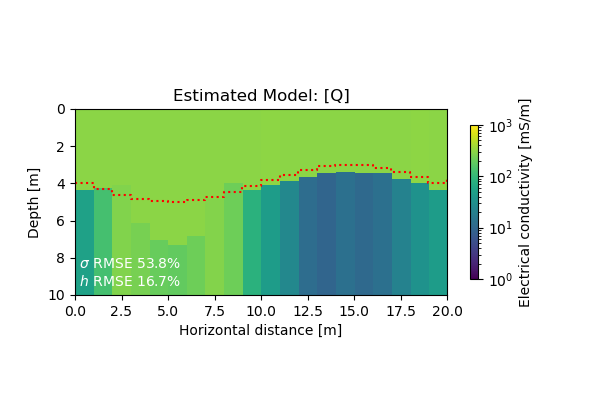

In [84]:
# Results of estimated model

sigmas_est_Q = model_est_Q[:,:2]
depth_est_Q = np.zeros_like(depths_true)
depth_est_Q[:,1] = model_est_Q[:,2]

PlotModelCond_2lay(sigmas_est_Q, depth_est_Q, depths_true)
RMSE_cond = rmse_a(np.log10(np.hstack(sigmas_true)), np.log10(np.hstack(sigmas_est_Q)))
RMSE_thk = rmse_a(depth_est_Q[:,1], depths_true[:,1])
plt.title('Estimated Model: [Q]')
plt.text(0,9.5,' $\sigma$ RMSE %.3g' %(RMSE_cond*100) + '%' 
          +' \n $h$ RMSE %.3g' %(RMSE_thk*100) +'%', color='w')
plt.show()

### Optimization using IP

In [85]:
# Create forward modeller class

class EMforward_IP(pg.Modelling):
    def __init__(self):
        """Initialize the model."""
        super().__init__()        
    def response(self, x):
        sig1 = x[0]
        sig2 = x[1]
        thick1 = x[2]
        Z = EMforward2lay(sig1, sig2, thick1)                           
        return Z[9:]               
    def createStartModel(self, dataVals):
        thk_ini = [3]
        sig_ini =[1/5, 1/100]
        x0 = sig_ini + thk_ini
        return np.array(x0)

In [86]:
# Initialize the forward modelling class
EMf_IP = EMforward_IP()

# Define inversion transformations
transData = pg.trans.TransLog() # log transformation for data
transModel = pg.trans.TransLog()  # log-transform ensures thk and res >0

# Create inversion
invEM = pg.Inversion()
invEM.setForwardOperator(EMf_IP)

invEM.transModel = transModel
invEM.transData = transData

# Relative error array
error = 1e-3 # introduce here the error you want to test
relativeError = np.ones_like(data_true[0, 9:]) * error

# Start inversion

model_est_IP = np.zeros_like(model_true)
#chi2hist = [] # empty array to store the chi2 history
#modelhist = [] # empty array to store the model history

npos = len(data_true)

# Perform inversion for each 1D model per position in stitched section
for pos in range(npos):
    dataE = data_true[pos,9:].copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0
    model_est_pos = invEM.run(dataE, relativeError, verbose=False, lam=100, maxIter=40)
   # chi2hist.append(invEM.chi2History)
   # modelhist.append(invEM.modelHistory)
    model_est_IP[pos] = model_est_pos

17/07/23 - 14:02:55 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:02:56 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:02:57 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:02:58 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:02:58 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:02:59 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:02:59 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:03:00 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:03:01 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:03:01 - pyGIMLi - INFO - Created startmodel from forward operator: [0.2  0.01 3.  ]
17/07/23 - 14:03:02 

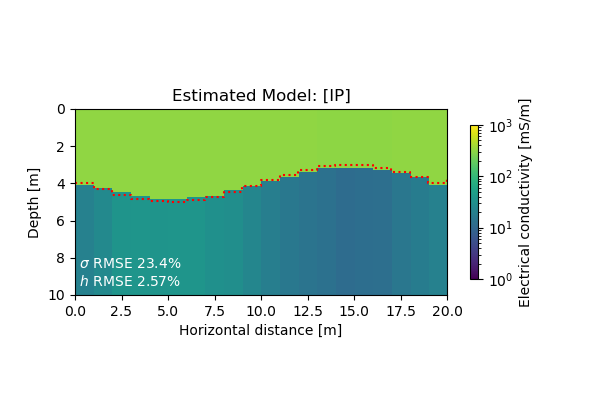

In [87]:
# Results of estimated model

sigmas_est_IP = model_est_IP[:,:2]
depth_est_IP = np.zeros_like(depths_true)
depth_est_IP[:,1] = model_est_IP[:,2]

PlotModelCond_2lay(sigmas_est_IP, depth_est_IP, depths_true)
RMSE_cond = rmse_a(np.log10(np.hstack(sigmas_true)), np.log10(np.hstack(sigmas_est_IP)))
RMSE_thk = rmse_a(depth_est_IP[:,1], depths_true[:,1])
plt.title('Estimated Model: [IP]')
plt.text(0,9.5,' $\sigma$ RMSE %.3g' %(RMSE_cond*100) + '%' 
          +' \n $h$ RMSE %.3g' %(RMSE_thk*100) +'%', color='w')
plt.show()

In [71]:
# Save estimated models

np.save('../data/model_est_', model)